# SARIMAX

## Setup

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from pmdarima import auto_arima

from collections import OrderedDict

# load self-written functions
from own_functions import model_classification
from own_functions import log_cases

In [2]:
# Matplotlib configuration for plots within the notebook
plt.rcParams['figure.figsize'] = [10, 5]

### Functions to evaluate SARIMAX with different p and q 
Within the functions different SARIMAX models will be setup and fitted with different p and q values. In a grid-search-like manner the RMSE of each model will be given. The functions test a range of values starting with 0 up to the defined value. 

In [3]:
# function which tests a range in p, q, P and Q. 
def SARIMAX_evaluation(train, test, exogs, max_p=3, max_q=3, max_P=1, max_Q=1, d=1, D=0, verbose=False):
    """
    Function tests out a range of combinations (arise from the given maximum values) of SARIMAX 
    hyperparameter (p, q, P and Q).
    
    ----------
    Parameters:
    
    train: taining dataframe
    test: test dataframe
    exogs: list, name of exogenous variables wich should be included in SARIMAX as external variables
    max_p: maximum value of p which should be tested starting from 0
    max_q: maximum value of q which should be tested starting from 0
    max_P: maximum value of P which should be tested starting from 0
    max_Q: maximum value of Q which should be tested starting from 0
    d: int, for SARIMAX differences
    D: int, for SARIMAX seasonal differences
    
    ----------
    Returns 
    
    results: dictionary with the tested combination as key and the corresponding RSME as value
    
    """
    results = {}
    for p in range(0,max_p+1):
        for q in range(0,max_q+1):
            for P in range(0,max_P+1):
                for Q in range(0,max_Q1+1):
                    try:
                        model = SARIMAX(train.total_cases, 
                                       order=(p, d, q),
                                       seasonal_order=(P, D, Q, 12),
                                       exog=train[exogs])
                        res = model.fit(disp=0)
                        pred = res.forecast(len(test.total_cases), exog=test[exogs])
                        rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                        results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = rmse
                        if verbose:
                            print(f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}: RSME {rmse}')

                    except ValueError:
                        results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

In [4]:
# function which tests a range in p and q (P and Q set to one level).
def SARIMAX_evaluation_pq(train, test, exogs, max_p=3, max_q=3, P=1, Q=1, d=1, D=0, verbose=False):
    """
    Function tests out a range of combinations (arise from the given maximum values) of SARIMAX 
    hyperparameter (p, q, P and Q).
    
    ----------
    Parameters:
    
    train: taining dataframe
    test: test dataframe
    exogs: list, name of exogenous variables wich should be included in SARIMAX as external variables
    max_p: maximum value of p which should be tested starting from 0
    max_q: maximum value of q which should be tested starting from 0
    P: int, for SARIMAX P (seasonal AR parameters)
    Q: int, for SARIMAX Q (seasonal MA parameters)
    d: int, for SARIMAX differences
    D: int, for SARIMAX seasonal differences
    
    ----------
    Returns 
    
    results: dictionary with the tested combination as key and the corresponding RSME as value
    
    """
    results = {}
    for p in range(0,max_p+1):
        for q in range(0,max_q+1):
            try:
                model = SARIMAX(train.total_cases, 
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, 12),
                               exog=train[exogs])
                res = model.fit(disp=0, maxiter=400, method_kwargs={"warn_convergence": False})
                pred = res.forecast(len(test.total_cases), exog=test[exogs])
                rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                results[f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q})'] = rmse
                if verbose:
                    print(f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q}): RSME {rmse}')

            except ValueError:
                results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

In [5]:
# function which tests a range in P and Q (p and q set to one level).
def SARIMAX_evaluation_PQ(train, test, exogs, max_P=3, max_Q=3, p=1, q=1, d=1, D=0, verbose=False):
    """
    Function tests out a range of combinations (arise from the given maximum values) of SARIMAX 
    hyperparameter (p, q, P and Q).
    
    ----------
    Parameters:
    
    train: taining dataframe
    test: test dataframe
    exogs: list, name of exogenous variables wich should be included in SARIMAX as external variables
    p: int, for SARIMAX p (AR parameters)
    q: int, for SARIMAX a (MA parameters)
    max_P: maximum value of P which should be tested starting from 0
    max_Q: maximum value of Q which should be tested starting from 0
    d: int, for SARIMAX differences
    D: int, for SARIMAX seasonal differences
    
    ----------
    Returns 
    
    results: dictionary with the tested combination as key and the corresponding RSME as value
    
    """
    results = {}
    for P in range(0,max_P+1):
        for Q in range(0,max_Q+1):
            try:
                model = SARIMAX(train.total_cases, 
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, 12),
                               exog=train[exogs])
                res = model.fit(disp=0, maxiter=400, method_kwargs={"warn_convergence": False})
                pred = res.forecast(len(test.total_cases), exog=test[exogs])
                rmse = round(np.sqrt(mean_squared_error(test.total_cases, pred)),2)
                results[f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q})'] = rmse
                if verbose:
                    print(f'Combination: ({p}, {d}, {q}), ({P}, {D}, {Q}): RSME {rmse}')

            except ValueError:
                results[f'Combination: p = {p}, q = {q}, P= {P}, Q= {Q}'] = np.nan
    return results

### Load the data

In [6]:
data_subsets_lags = pickle.load(open('data_subsets_lags.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_lags

In [7]:
# get log of cases as column
sj_train_train = log_cases(sj_train_train)
sj_train_test = log_cases(sj_train_test)
iq_train_train = log_cases(iq_train_train)
iq_train_test = log_cases(iq_train_test)

In [8]:
# delete non-numeric columns
sj_train_train = sj_train_train.select_dtypes(include='number')
iq_train_train = iq_train_train.select_dtypes(include='number')

In [9]:
# delet also NAN included by lagged precipitation 
sj_train_train = sj_train_train.dropna()
sj_train_test = sj_train_test.dropna()
iq_train_train = iq_train_train.dropna()
iq_train_test = iq_train_test.dropna()

### Scaler

In [10]:
# get a list with names of the features
features = sj_train_train.columns.tolist()
not_features = ['logged_cases', 'total_cases', 'month', 'weekofyear', 'year']
features = [x for x in features if x not in not_features]

In [11]:
sj_scaler = StandardScaler()
# get the scaled feature values for sj_train_train (fit and transform)
sj_train_train_s = sj_scaler.fit_transform(sj_train_train[features])
# only transform the features from the sj_train_test dataframe
sj_train_test_s = sj_scaler.transform(sj_train_test[features])

# format the subset with scaled features to a dataframe with correct feature names
sj_train_train_s = pd.DataFrame(sj_train_train_s)
sj_train_train_s.columns = features
sj_train_train_s.index = sj_train_train.index
sj_train_test_s = pd.DataFrame(sj_train_test_s)
sj_train_test_s.columns = features
sj_train_test_s.index = sj_train_test.index

# combine the scaled data with the non-scaled features
sj_train_train_scaled = sj_train_train[not_features]
sj_train_train_scaled = sj_train_train_scaled.join(sj_train_train_s)
sj_train_test_scaled = sj_train_test[not_features]
sj_train_test_scaled = sj_train_test_scaled.join(sj_train_test_s)

In [12]:
iq_scaler = StandardScaler()
# get the scaled feature values for iq_train_train (fit and transform)
iq_train_train_s = iq_scaler.fit_transform(iq_train_train[features])
# only transform the features from the iq_train_test dataframe
iq_train_test_s = iq_scaler.transform(iq_train_test[features])

# format the subset with scaled features to a dataframe with correct feature names
iq_train_train_s = pd.DataFrame(iq_train_train_s)
iq_train_train_s.columns = features
iq_train_train_s.index = iq_train_train.index
iq_train_test_s = pd.DataFrame(iq_train_test_s)
iq_train_test_s.columns = features
iq_train_test_s.index = iq_train_test.index

# combine the scaled data with the non-scaled features
iq_train_train_scaled = iq_train_train[not_features]
iq_train_train_scaled = iq_train_train_scaled.join(iq_train_train_s)
iq_train_test_scaled = iq_train_test[not_features]
iq_train_test_scaled = iq_train_test_scaled.join(iq_train_test_s)

In [13]:
sj_train_train_scaled = sj_train_train_scaled.dropna()
sj_train_test_scaled = sj_train_test_scaled.dropna()
iq_train_train_scaled = iq_train_train_scaled.dropna()
iq_train_test_scaled = iq_train_test_scaled.dropna()

## San Juan: Total cases (non-transformed)

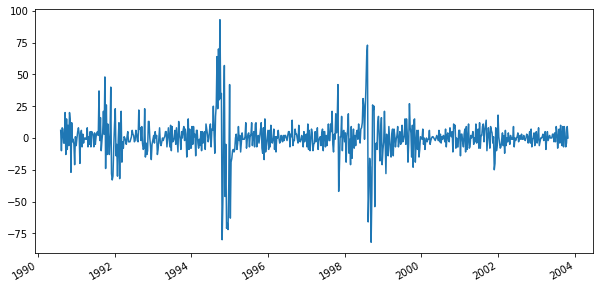

In [14]:
# first order differencing
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

sj_train_train_diff.total_cases.plot();

### ACF

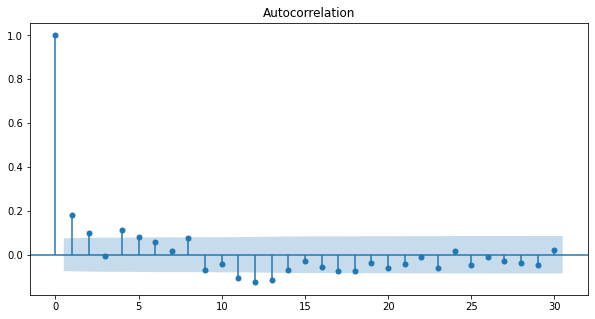

In [15]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.total_cases, lags=30);

### PCAF

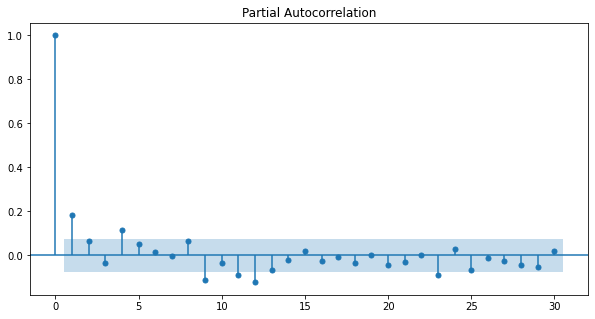

In [16]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.total_cases, lags=30);

### Feature selection

In [17]:
# get pearson correlation and get the 15 features with highest correlation
corr_mat = sj_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

station_avg_temp_c_lag8           0.354404
station_min_temp_c_lag8           0.351633
station_avg_temp_c_lag7           0.345911
station_min_temp_c_lag7           0.345745
station_min_temp_c_lag6           0.330478
station_avg_temp_c_lag6           0.328557
reanalysis_min_air_temp_c_lag8    0.315839
reanalysis_max_air_temp_c_lag8    0.315635
reanalysis_max_air_temp_c_lag7    0.315531
reanalysis_avg_temp_c_lag8        0.314542
transmission_probability_lag8     0.314373
infection_probability_lag8        0.314246
fecundity_lag8                    0.314227
mdr_lag8                          0.314152
biting_rate_lag8                  0.314092
Name: total_cases, dtype: float64

In [18]:
# put 15 features with highest correlation in list
sj_exogs = cases_corr_list[:15].index.tolist()

In [19]:
# to prevent errors index is dropped (and later added again)
sj_train_train_statsmodels = sj_train_train_scaled.reset_index(drop=True)
sj_train_test_statsmodels = sj_train_test_scaled.reset_index(drop=True)

### Evaluation of p and q

In [20]:
results_sj_pq = SARIMAX_evaluation_pq(train=sj_train_train_statsmodels, test=sj_train_test_statsmodels, exogs=sj_exogs)

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
results_sj_pq = OrderedDict(sorted(results_sj_pq.items(), key=lambda x: x[1]))
results_sj_pq

OrderedDict([('Combination: (0, 1, 0), (1, 0, 1)', 26.09),
             ('Combination: (2, 1, 2), (1, 0, 1)', 26.18),
             ('Combination: (0, 1, 1), (1, 0, 1)', 27.01),
             ('Combination: (1, 1, 2), (1, 0, 1)', 27.03),
             ('Combination: (1, 1, 3), (1, 0, 1)', 27.1),
             ('Combination: (0, 1, 3), (1, 0, 1)', 27.19),
             ('Combination: (1, 1, 0), (1, 0, 1)', 27.41),
             ('Combination: (2, 1, 1), (1, 0, 1)', 27.51),
             ('Combination: (3, 1, 1), (1, 0, 1)', 27.53),
             ('Combination: (3, 1, 3), (1, 0, 1)', 27.6),
             ('Combination: (3, 1, 0), (1, 0, 1)', 27.62),
             ('Combination: (0, 1, 2), (1, 0, 1)', 27.99),
             ('Combination: (2, 1, 0), (1, 0, 1)', 28.27),
             ('Combination: (2, 1, 3), (1, 0, 1)', 28.34),
             ('Combination: (1, 1, 1), (1, 0, 1)', 28.77),
             ('Combination: (3, 1, 2), (1, 0, 1)', 30.29)])

### Model

In [20]:
sj_order = (2, 1, 2) 
sj_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
sj_sarimax_model = SARIMAX(sj_train_train_statsmodels.total_cases, 
                           order=sj_order,
                           seasonal_order=sj_seasonal_order,
                           exog=sj_train_train_statsmodels[sj_exogs])
sj_sarimax_model_fit = sj_sarimax_model.fit(maxiter=400, disp=0)

In [21]:
print(sj_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  690
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -2800.797
Date:                              Tue, 10 Aug 2021   AIC                           5645.594
Time:                                      15:09:01   BIC                           5745.369
Sample:                                           0   HQIC                          5684.191
                                              - 690                                         
Covariance Type:                                opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
station_avg_temp_c_lag8           -0.4708      2.674     -

### Forecasting

In [22]:
# get predictions
sj_sarimax_model_pred = sj_sarimax_model_fit.forecast(len(sj_train_test_statsmodels.total_cases), exog=sj_train_test_statsmodels[sj_exogs])

In [23]:
# convert predictions to dataframe and set original index from train_test
sj_sarimax_model_pred = pd.Series(sj_sarimax_model_pred) 
sj_sarimax_model_pred.index=sj_train_test.index 

### Evaluation

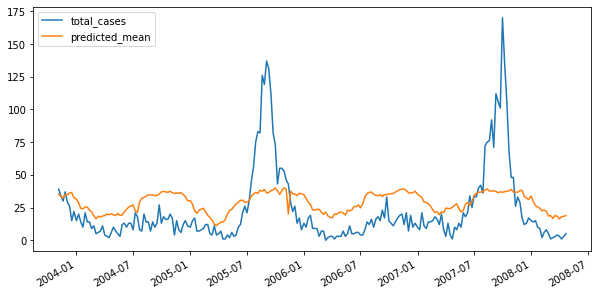

In [24]:
# plot the actual and predicted values
sj_train_test.total_cases.plot(legend=True)
sj_sarimax_model_pred.plot(legend=True);

In [25]:
# get model evaluation
model_classification(sj_train_test.total_cases, sj_sarimax_model_pred)

--------------------
RMSE: 26.18
--------------------
MAE: 19.43
Explained variance: 0.209
--------------------


## San Juan: Total cases (log-transformed)

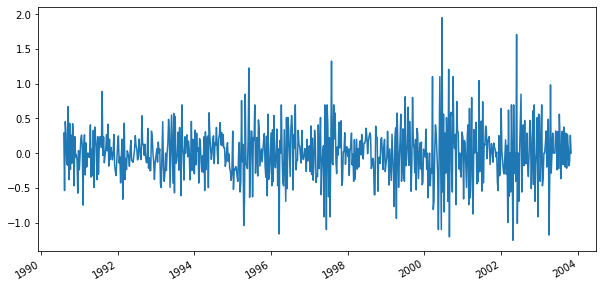

In [26]:
# first order differencing
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

sj_train_train_diff.logged_cases.plot();

### ACF

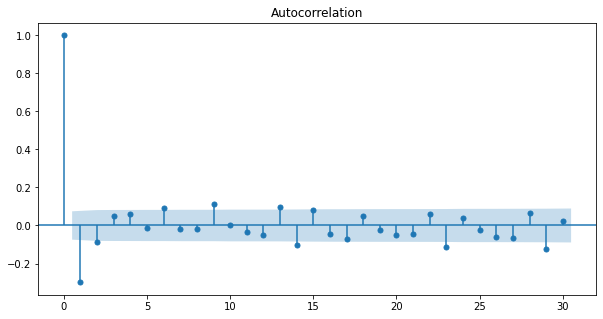

In [27]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.logged_cases, lags=30);

### PCAF

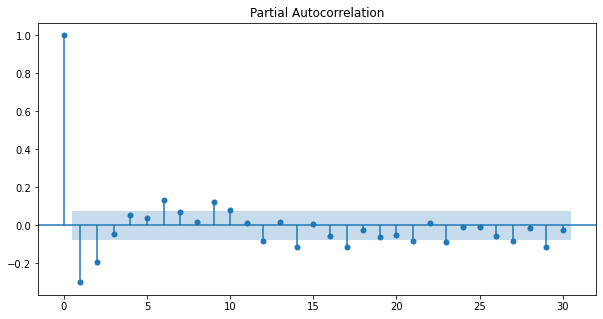

In [28]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.logged_cases, lags=30);

### Feature selection

In [29]:
# put 15 features with highest correlation in list
corr_mat = sj_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag8    0.502824
reanalysis_dew_point_temp_c_lag8              0.500359
reanalysis_specific_humidity_g_per_kg_lag7    0.480124
reanalysis_dew_point_temp_c_lag7              0.476841
station_avg_temp_c_lag8                       0.476745
reanalysis_min_air_temp_c_lag8                0.469055
station_min_temp_c_lag8                       0.464031
fecundity_lag8                                0.462976
reanalysis_max_air_temp_c_lag8                0.461717
transmission_probability_lag8                 0.460771
infection_probability_lag8                    0.460528
mdr_lag8                                      0.459655
biting_rate_lag8                              0.458917
reanalysis_min_air_temp_c_lag7                0.457994
pdr_lag8                                      0.457693
Name: logged_cases, dtype: float64

In [30]:
# put 15 features with highest correlation in list
sj_exogs = cases_corr_list[:30].index.tolist()

In [31]:
# to prevent errors index is dropped (and later added again)
sj_train_train_statsmodels = sj_train_train_scaled.reset_index(drop=True)
sj_train_test_statsmodels = sj_train_test_scaled.reset_index(drop=True)

### Model
From the ACF and PCAF we can see that 3 (AR) and 2 (MA) for the SARIMAX would be a good choice.

In [32]:
sj_order = (3, 0, 2) 
sj_seasonal_order = (1, 0, 1, 12) 
sj_sarimax_model = SARIMAX(sj_train_train_statsmodels.logged_cases, 
                           order=sj_order,
                           seasonal_order=sj_seasonal_order,
                           exog=sj_train_train_statsmodels[sj_exogs])
sj_sarimax_model_fit = sj_sarimax_model.fit(maxiter=400, disp=0)

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
print(sj_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         logged_cases   No. Observations:                  690
Model:             SARIMAX(3, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -281.634
Date:                              Tue, 10 Aug 2021   AIC                            639.268
Time:                                      15:10:34   BIC                            811.663
Sample:                                           0   HQIC                           705.953
                                              - 690                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

### Forecasting

In [34]:
# get predictions
sj_sarimax_model_pred_log = sj_sarimax_model_fit.forecast(len(sj_train_test_statsmodels.logged_cases), exog=sj_train_test_statsmodels[sj_exogs])

In [35]:
# convert predictions to normal-scale
sj_sarimax_model_pred = np.exp(sj_sarimax_model_pred_log)-1

# convert predictions to dataframe and set original index from train_test
sj_sarimax_model_pred = pd.Series(sj_sarimax_model_pred) 
sj_sarimax_model_pred.index=sj_train_test.index 

### Evaluation

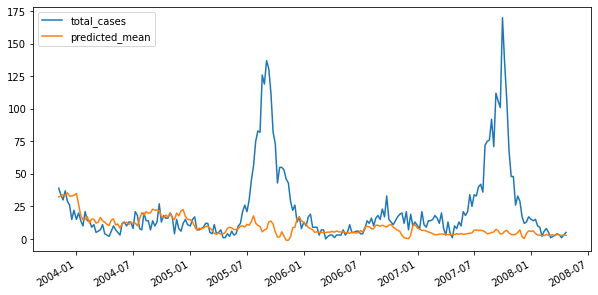

In [36]:
# plot actual and predicted values
sj_train_test.total_cases.plot(legend=True)
sj_sarimax_model_pred.plot(legend=True);

In [37]:
# model evaluation
model_classification(sj_train_test.total_cases, sj_sarimax_model_pred)

--------------------
RMSE: 32.51
--------------------
MAE: 16.77
Explained variance: -0.081
--------------------


# Iquitos: Total cases (non-transformed)

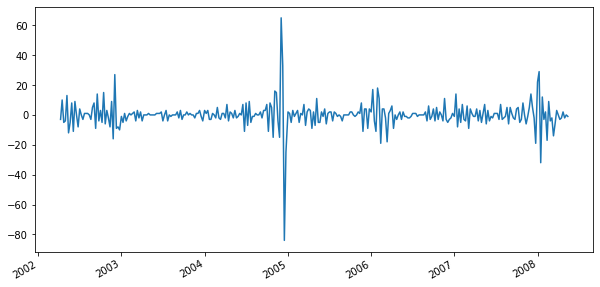

In [38]:
# first order differencing
iq_train_train_diff = iq_train_train - iq_train_train.shift(1)
iq_train_train_diff = iq_train_train_diff.dropna()

iq_train_train_diff.total_cases.plot();

### ACF

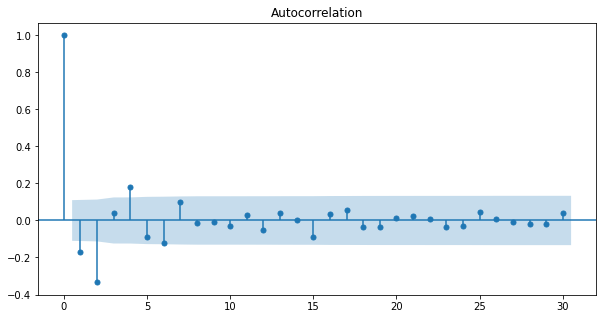

In [39]:
# Check the PACF for the optimal number of lags
plot_acf(iq_train_train_diff.total_cases, lags=30);

### PCAF

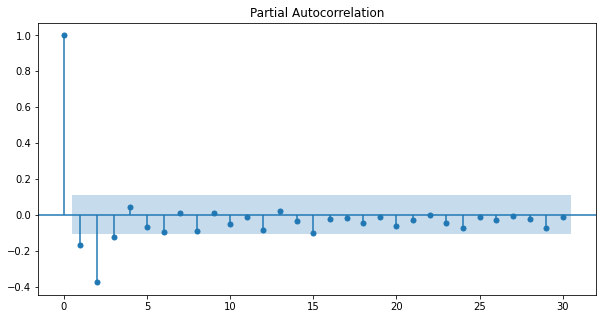

In [40]:
# Check the PACF for the optimal number of lags
plot_pacf(iq_train_train_diff.total_cases, lags=30);

## Feature selection

In [41]:
# put 15 features with highest correlation in list
corr_mat = iq_train_train.corr()
cases_corr_list = (
    corr_mat['total_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag2    0.207099
reanalysis_min_air_temp_c                     0.205019
reanalysis_min_air_temp_c_lag2                0.199620
reanalysis_specific_humidity_g_per_kg_lag1    0.199519
reanalysis_dew_point_temp_c_lag2              0.199417
reanalysis_dew_point_temp_c_lag1              0.193619
fecundity_lag7                                0.189499
fecundity_lag5                                0.187945
reanalysis_specific_humidity_g_per_kg         0.187924
transmission_probability_lag7                 0.187838
infection_probability_lag7                    0.187705
reanalysis_specific_humidity_g_per_kg_lag3    0.187383
mdr_lag7                                      0.187075
biting_rate_lag7                              0.186516
transmission_probability_lag5                 0.185981
Name: total_cases, dtype: float64

In [42]:
# put 15 features with highest correlation in list
iq_exogs = cases_corr_list[:15].index.tolist()

In [43]:
# to prevent errors index is dropped (and later added again)
iq_train_train_statsmodels = iq_train_train_scaled.reset_index(drop=True)
iq_train_test_statsmodels = iq_train_test_scaled.reset_index(drop=True)

### Model
From the ACF and PCAF we can see that 3 (AR) and 3 (MA) for the SARIMAX would be a good choice.

In [44]:
iq_order = (3, 0, 3) # Non-seasonal mid1 because differencing with order 1
iq_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
iq_sarimax_model = SARIMAX(iq_train_train_statsmodels.total_cases, 
                           order=iq_order,
                           seasonal_order=iq_seasonal_order,
                           exog=iq_train_train_statsmodels[iq_exogs])
iq_sarimax_model_fit = iq_sarimax_model.fit(maxiter=400, disp=0)

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
print(iq_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          total_cases   No. Observations:                  319
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood               -1112.412
Date:                              Tue, 10 Aug 2021   AIC                           2272.824
Time:                                      15:10:58   BIC                           2363.189
Sample:                                           0   HQIC                          2308.912
                                              - 319                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

### Forecasting

In [46]:
# get predictions
iq_sarimax_model_pred = iq_sarimax_model_fit.forecast(len(iq_train_test_statsmodels.total_cases), exog=iq_train_test_statsmodels[iq_exogs])

In [47]:
# convert predictions to dataframe and set original index from train_test
iq_sarimax_model_pred = pd.Series(iq_sarimax_model_pred) 
iq_sarimax_model_pred.index=iq_train_test.index 

### Evaluation

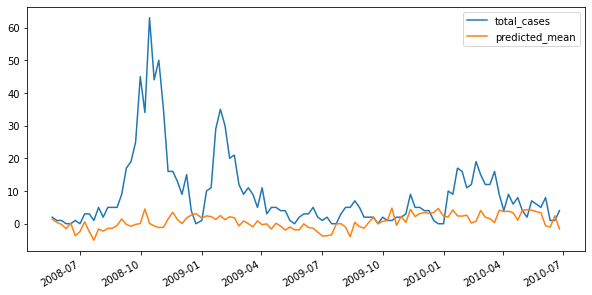

In [48]:
# plot actual and predicted values
iq_train_test.total_cases.plot(legend=True)
iq_sarimax_model_pred.plot(legend=True);

In [49]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_sarimax_model_pred)

--------------------
RMSE: 14.05
--------------------
MAE: 8.76
Explained variance: -0.002
--------------------


# Iquitos: Total cases (non-transformed)

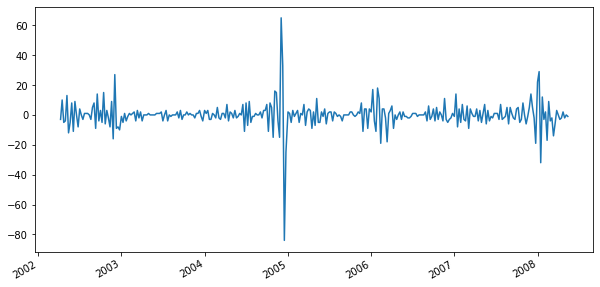

In [50]:
# first order differencing
iq_train_train_diff = iq_train_train - iq_train_train.shift(1)
iq_train_train_diff = iq_train_train_diff.dropna()

iq_train_train_diff.total_cases.plot();

### ACF

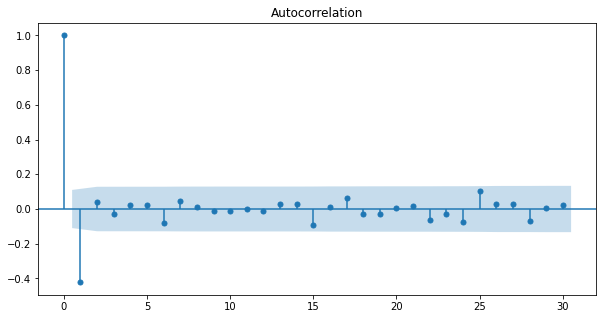

In [51]:
# Check the PACF for the optimal number of lags
plot_acf(iq_train_train_diff.logged_cases, lags=30);

### PCAF

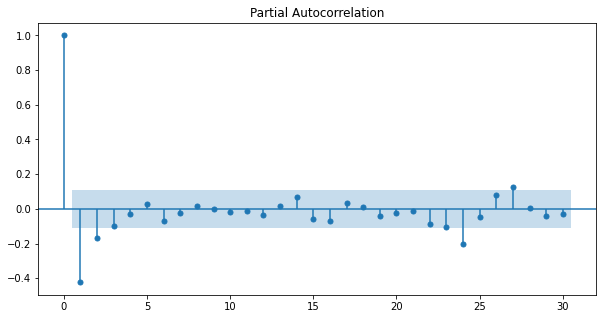

In [52]:
# Check the PACF for the optimal number of lags
plot_pacf(iq_train_train_diff.logged_cases, lags=30);

### Feature selection

In [53]:
# put 15 features with highest correlation in list
corr_mat = iq_train_train_scaled.corr()
cases_corr_list = (
    corr_mat['logged_cases']
    .drop(['logged_cases', 'total_cases', 'month', 'weekofyear', 'year'], axis=0)
    .abs()
    .sort_values(ascending=False)
)
cases_corr_list[:15]

reanalysis_specific_humidity_g_per_kg_lag3    0.272324
reanalysis_dew_point_temp_c_lag3              0.266025
reanalysis_min_air_temp_c_lag3                0.263004
reanalysis_min_air_temp_c_lag5                0.251482
reanalysis_min_air_temp_c_lag4                0.250022
reanalysis_specific_humidity_g_per_kg_lag5    0.249386
reanalysis_specific_humidity_g_per_kg_lag2    0.247081
reanalysis_min_air_temp_c_lag2                0.245847
reanalysis_specific_humidity_g_per_kg_lag1    0.245220
reanalysis_dew_point_temp_c_lag5              0.245193
reanalysis_dew_point_temp_c_lag1              0.240080
reanalysis_dew_point_temp_c_lag2              0.239024
reanalysis_specific_humidity_g_per_kg         0.234172
reanalysis_min_air_temp_c_lag1                0.232481
reanalysis_min_air_temp_c                     0.226011
Name: logged_cases, dtype: float64

In [54]:
# put 15 features with highest correlation in list
iq_exogs = cases_corr_list[:15].index.tolist()

In [55]:
# to prevent errors index is dropped (and later added again)
iq_train_train_statsmodels = iq_train_train_scaled.reset_index(drop=True)
iq_train_test_statsmodels = iq_train_test_scaled.reset_index(drop=True)

### Model
From the ACF and PCAF we can see that 2 (AR) and 2 (MA) for the SARIMAX would be a good choice.

In [56]:
iq_order = (2, 1, 2) # Non-seasonal mid1 because differencing with order 1
iq_seasonal_order = (1, 0, 1, 12) # Seasonal 12 for 12 months
iq_sarimax_model = SARIMAX(iq_train_train_statsmodels.logged_cases, 
                           order=iq_order,
                           seasonal_order=iq_seasonal_order,
                           exog=iq_train_train_statsmodels[iq_exogs])
iq_sarimax_model_fit = iq_sarimax_model.fit(maxiter=400, disp=0)

/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/cramer/neuefische/DenguePred/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [57]:
print(iq_sarimax_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         logged_cases   No. Observations:                  319
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -273.753
Date:                              Tue, 10 Aug 2021   AIC                            591.507
Time:                                      15:11:12   BIC                            674.272
Sample:                                           0   HQIC                           624.564
                                              - 319                                         
Covariance Type:                                opg                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
reanalysis_specific_humidity_g_per

### Forecasting

In [58]:
# get predictions
iq_sarimax_model_pred_log = iq_sarimax_model_fit.forecast(len(iq_train_test_statsmodels.total_cases), exog=iq_train_test_statsmodels[iq_exogs])

In [59]:
# convert predictions to normal-scale
iq_sarimax_model_pred = np.exp(iq_sarimax_model_pred_log)-1

# convert predictions to dataframe and set original index from train_test
iq_sarimax_model_pred = pd.Series(iq_sarimax_model_pred) 
iq_sarimax_model_pred.index=iq_train_test.index 

### Evaluation

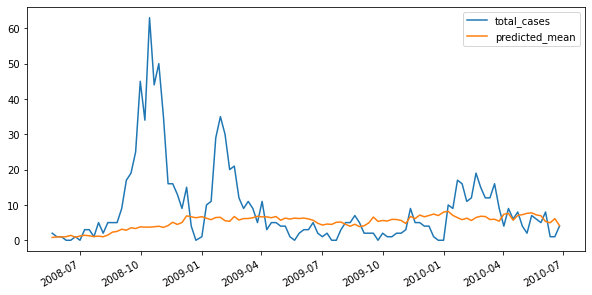

In [60]:
# plot actual and predicted values
iq_train_test.total_cases.plot(legend=True)
iq_sarimax_model_pred.plot(legend=True);

In [61]:
# model evaluation
model_classification(iq_train_test.total_cases, iq_sarimax_model_pred)

--------------------
RMSE: 12.12
--------------------
MAE: 6.93
Explained variance: -0.035
--------------------
